In [1]:
# SETUP AND IMPORTS
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import warnings
import sys

# --- PyTorch and Sklearn Imports ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
from sklearn.metrics import average_precision_score

# --- TensorFlow for Data Loading ONLY ---
import tensorflow as tf

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Define data directory 
DATA_DIR = Path("../../data/raw/ndws_western_dataset")
print(f"📁 Data directory: {DATA_DIR}")
print(f"📂 Directory exists: {DATA_DIR.exists()}")

# Import necessary functions from other notebooks/modules
sys.path.append('../../src')

# --- CORRECTED TFRecord PARSING FUNCTION ---
def parse_tfrecord_flexible(example):
    """
    Parse TFRecord with the CORRECT feature description.
    Instead of assuming string, we now correctly specify a 64x64 float tensor.
    """
    feature_description = {}
    
    expected_features = [
        'elevation', 'NDVI', 'erc', 'pr', 'pdsi', 'population',
        'impervious', 'water', 'tmp_day', 'tmp_75', 'wind_avg', 'wind_75',
        'wdir_wind', 'wdir_gust', 'gust_med', 'avg_sph', 'bi', 'chili',
        'fuel1', 'fuel2', 'fuel3', 'viirs_PrevFireMask', 'viirs_FireMask'
    ]
    
    # CRITICAL FIX: We now tell TensorFlow to expect a 64x64 array of floats.
    for feat in expected_features:
        feature_description[feat] = tf.io.FixedLenFeature([64, 64], tf.float32)
    
    parsed_features = tf.io.parse_single_example(example, feature_description)
    return parsed_features

# NOTE: The decode_feature function is no longer needed and has been removed.

print("\n✅ Setup complete - data loading functions are now corrected!")

📁 Data directory: ..\..\data\raw\ndws_western_dataset
📂 Directory exists: True

✅ Setup complete - data loading functions are now corrected!


In [2]:
# VISUALIZATION FUNCTIONS (PYTORCH VERSION)
def visualize_fire_predictions_pytorch(model, X_test, y_test, num_samples=4):
    """Visualize fire prediction results from a PyTorch model"""
    if len(X_test) == 0:
        print("❌ No test samples available for visualization")
        return

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    X_test_subset = X_test[:num_samples]
    y_test_subset = y_test[:num_samples]
    
    with torch.no_grad():
        # Transpose from (N, H, W, C) to (N, C, H, W) for PyTorch
        X_test_tensor = torch.from_numpy(np.transpose(X_test_subset, (0, 3, 1, 2))).float().to(device)
        predictions_tensor = model(X_test_tensor)
        # Transpose back to (N, H, W, C) for visualization with Matplotlib
        predictions = np.transpose(predictions_tensor.cpu().numpy(), (0, 2, 3, 1))

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_samples):
        input_fire = X_test_subset[i, :, :, 0]
        true_fire = y_test_subset[i, :, :, 0]
        pred_fire = predictions[i, :, :, 0]

        axes[i, 0].imshow(input_fire, cmap='Reds', vmin=0, vmax=1)
        axes[i, 0].set_title(f'Sample {i+1}: Input Fire (t)')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(true_fire, cmap='Reds', vmin=0, vmax=1)
        # --- CORRECTED LABEL ---
        axes[i, 1].set_title(f'True Fire (t+1)')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred_fire, cmap='Reds', vmin=0, vmax=1)
        # --- CORRECTED LABEL ---
        axes[i, 2].set_title(f'Predicted Fire (t+1)')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"\n📊 PREDICTION STATISTICS:")
    print(f"🔥 True fire pixels in displayed samples: {np.sum(y_test_subset > 0.1)}")
    print(f"🎯 Predicted fire pixels (threshold > 0.5): {np.sum(predictions > 0.5)}")
    print(f"📈 Average prediction confidence: {np.mean(predictions):.4f}")

print("✅ PyTorch visualization function defined with corrected t+1 labels!")

✅ PyTorch visualization function defined with corrected t+1 labels!


# 🔥 SPATIAL FIRE SPREAD PREDICTION WITH U-NET ARCHITECTURE

**CRITICAL FIX**: This section implements proper spatial fire spread prediction using:
- ✅ **Raw spatial features** (64x64 grids) - NOT statistical summaries
- ✅ **All 23 environmental features** as spatial inputs
- ✅ **U-Net architecture** for pixel-level fire spread prediction
- ✅ **Temporal prediction**: PrevFireMask(t) → FireMask(t+1)
- ✅ **Research-based approach** following wildfire prediction literature

**Key Point**: The engineered features above are for EDA/visualization only. All prediction uses RAW SPATIAL DATA.

In [3]:
# --- FINAL DATA PROCESSOR: COMBINING TIME-SERIES AND CURRENT DAY DATA ---

class CombinedFireDataProcessor:
    """
    Processes data to give the model the best of both worlds:
    - Historical environmental context (from the past)
    - Current day fire and environmental state
    """
    def __init__(self, data_dir=DATA_DIR, num_timesteps=4):
        self.data_dir = data_dir
        self.num_timesteps = num_timesteps # Past days of environmental data
        self.environmental_features = [
            'elevation', 'NDVI', 'erc', 'pr', 'pdsi', 'population',
            'impervious', 'water', 'tmp_day', 'tmp_75', 'wind_avg', 'wind_75',
            'wdir_wind', 'wdir_gust', 'gust_med', 'avg_sph', 'bi', 'chili',
            'fuel1', 'fuel2', 'fuel3'
        ]

    def load_raw_spatial_data(self, max_sequences=None):
        """
        Load and create the ultimate time-series sequences.
        Input X: viirs_PrevFireMask(t) + Env Features(t-4 to t-1) + Env Features(t)
        Target Y: viirs_FireMask(t+1)
        """
        print("🔥 Loading RAW SPATIAL DATA for COMBINED (Time-Series + Current Day) prediction...")
        
        tfrecord_files = list(self.data_dir.glob("*.tfrecord"))
        if not tfrecord_files:
            print("❌ No TFRecord files found!")
            return None, None
        print(f"📁 Found {len(tfrecord_files)} TFRecord files")

        all_samples_flat = []
        # Load all daily snapshots into one list
        for file_path in tfrecord_files:
            dataset = tf.data.TFRecordDataset(str(file_path))
            for raw_record in dataset:
                try:
                    parsed_sample = parse_tfrecord_flexible(raw_record)
                    sample_data = {name: tensor.numpy() for name, tensor in parsed_sample.items()}
                    if 'viirs_PrevFireMask' in sample_data and 'viirs_FireMask' in sample_data:
                        all_samples_flat.append(sample_data)
                except Exception as e:
                    print(f"❗️ FAILED TO PROCESS A RECORD in {file_path.name}. Error: {e}")
                    break
            else: continue
            break
        
        print(f"  ...Loaded {len(all_samples_flat)} total individual samples.")

        if not all_samples_flat:
             print("❌ No valid samples were loaded.")
             return None, None

        # --- COMBINED SLIDING WINDOW LOGIC ---
        spatial_inputs, spatial_targets = [], []
        # Total window size = num_timesteps (past env) + 1 (current day) + 1 (target day)
        sequence_len = self.num_timesteps + 2
        
        for i in range(len(all_samples_flat) - sequence_len):
            if max_sequences and len(spatial_inputs) >= max_sequences:
                break

            # Define the time windows
            past_environmental_sequence = all_samples_flat[i : i + self.num_timesteps] # t-4 to t-1
            current_day_sample = all_samples_flat[i + self.num_timesteps]              # day 't'
            next_day_sample = all_samples_flat[i + self.num_timesteps + 1]           # day 't+1'

            # --- Assemble the Input Tensor (X) ---
            input_features = []
            
            # 1. Add the fire mask from the CURRENT day (t)
            input_features.append(current_day_sample['viirs_PrevFireMask'].reshape(64, 64, 1))

            # 2. Add environmental features from the PAST days (t-4 to t-1)
            for past_sample in past_environmental_sequence:
                for feature_name in self.environmental_features:
                    if feature_name in past_sample:
                        input_features.append(past_sample[feature_name].reshape(64, 64, 1))
            
            # 3. Add environmental features from the CURRENT day (t)
            for feature_name in self.environmental_features:
                 if feature_name in current_day_sample:
                    input_features.append(current_day_sample[feature_name].reshape(64, 64, 1))

            # --- Assemble the Target Tensor (y) ---
            target_mask = next_day_sample['viirs_FireMask'].reshape(64, 64, 1)

            if len(input_features) > 1:
                spatial_inputs.append(np.concatenate(input_features, axis=2))
                spatial_targets.append(target_mask)

        if not spatial_inputs:
            print("❌ Could not create any sequences with the combined logic!")
            return None, None
            
        X_spatial = np.array(spatial_inputs, dtype=np.float32)
        y_spatial = np.array(spatial_targets, dtype=np.float32)

        print(f"\n✅ COMBINED DATA LOADING COMPLETE")
        print(f"📊 Spatial Input Shape: {X_spatial.shape}")
        print(f"📊 Spatial Target Shape: {y_spatial.shape}")
        return X_spatial, y_spatial

In [4]:
# --- PYTORCH UNET++ ARCHITECTURE, LOSS FUNCTION, AND TRAINING FUNCTION ---

# --- 1. LOSS FUNCTION: BCE + Dice (Unchanged) ---
class BCEDiceLoss(nn.Module):
    def __init__(self, weight=0.5):
        super(BCEDiceLoss, self).__init__()
        self.weight = weight

    def forward(self, inputs, targets, smooth=1e-6):
        inputs_flat = inputs.view(-1)
        targets_flat = targets.view(-1)
        bce_loss = nn.BCELoss()(inputs_flat, targets_flat)
        intersection = (inputs_flat * targets_flat).sum()
        dice_score = (2. * intersection + smooth) / (inputs_flat.sum() + targets_flat.sum() + smooth)
        dice_loss = 1 - dice_score
        return self.weight * bce_loss + (1 - self.weight) * dice_loss

# --- 2. U-NET++ MODEL DEFINITION IN PYTORCH ---
# --- PYTORCH UNET++ ARCHITECTURE (WITH BATCH NORMALIZATION) ---
class FireUNetPlusPlus(nn.Module):
    """
    UNet++ with the CRITICAL addition of Batch Normalization to stabilize training.
    """
    def __init__(self, in_channels, out_channels, filters_base=32):
        super(FireUNetPlusPlus, self).__init__()

        # --- MODIFIED CONV BLOCK WITH BATCH NORMALIZATION ---
        def _conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1, bias=False),
                nn.BatchNorm2d(out_c), # Add BatchNorm
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1, bias=False),
                nn.BatchNorm2d(out_c), # Add BatchNorm
                nn.ReLU(inplace=True)
            )

        # The rest of the U-Net++ architecture is IDENTICAL
        nb_filter = [filters_base, filters_base*2, filters_base*4, filters_base*8, filters_base*16]
        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv0_0 = _conv_block(in_channels, nb_filter[0])
        self.conv1_0 = _conv_block(nb_filter[0], nb_filter[1])
        self.conv2_0 = _conv_block(nb_filter[1], nb_filter[2])
        self.conv3_0 = _conv_block(nb_filter[2], nb_filter[3])
        self.conv4_0 = _conv_block(nb_filter[3], nb_filter[4])
        self.conv0_1 = _conv_block(nb_filter[0]+nb_filter[1], nb_filter[0])
        self.conv1_1 = _conv_block(nb_filter[1]+nb_filter[2], nb_filter[1])
        self.conv2_1 = _conv_block(nb_filter[2]+nb_filter[3], nb_filter[2])
        self.conv3_1 = _conv_block(nb_filter[3]+nb_filter[4], nb_filter[3])
        self.conv0_2 = _conv_block(nb_filter[0]*2+nb_filter[1], nb_filter[0])
        self.conv1_2 = _conv_block(nb_filter[1]*2+nb_filter[2], nb_filter[1])
        self.conv2_2 = _conv_block(nb_filter[2]*2+nb_filter[3], nb_filter[2])
        self.conv0_3 = _conv_block(nb_filter[0]*3+nb_filter[1], nb_filter[0])
        self.conv1_3 = _conv_block(nb_filter[1]*3+nb_filter[2], nb_filter[1])
        self.conv0_4 = _conv_block(nb_filter[0]*4+nb_filter[1], nb_filter[0])
        self.final = nn.Conv2d(nb_filter[0], out_channels, kernel_size=1)

    def forward(self, input):
        # The forward pass is IDENTICAL
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))
        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))
        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))
        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))
        output = self.final(x0_4)
        return torch.sigmoid(output)


# --- The training function remains the same, just make sure to call the stabilized model ---
# (The rest of the cell with train_fire_unet_cv_pytorch is unchanged)


# --- 3. TRAINING FUNCTION (Modified to use FireUNetPlusPlus) ---
def train_fire_unet_cv_pytorch(X_spatial, y_spatial, n_splits=5, epochs=20, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"🚀 INITIATING U-NET++ TRAINING ON {device} WITH {n_splits}-FOLD CV")
    print(f"🎯 Main Metric: Average Precision (AP)")
    print("=" * 60)
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_ap_scores = []
    last_model = None

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_spatial)):
        print(f"\n========== FOLD {fold + 1}/{n_splits} ==========")
        X_train, X_val = X_spatial[train_idx], X_spatial[val_idx]
        y_train, y_val = y_spatial[train_idx], y_spatial[val_idx]

        X_train_t = np.transpose(X_train, (0, 3, 1, 2))
        X_val_t = np.transpose(X_val, (0, 3, 1, 2))
        y_train_t = (np.transpose(y_train, (0, 3, 1, 2)) > 0.1).astype(np.float32)
        y_val_t = (np.transpose(y_val, (0, 3, 1, 2)) > 0.1).astype(np.float32)
        
        channel_means = np.mean(X_train_t, axis=(0, 2, 3), keepdims=True)
        channel_stds = np.std(X_train_t, axis=(0, 2, 3), keepdims=True)
        channel_stds[channel_stds == 0] = 1

        X_train_norm = (X_train_t - channel_means) / channel_stds
        X_val_norm = (X_val_t - channel_means) / channel_stds
        
        train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train_norm), torch.from_numpy(y_train_t)), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(torch.from_numpy(X_val_norm), torch.from_numpy(y_val_t)), batch_size=batch_size, shuffle=False)
        
        # <<< CHANGE: Use FireUNetPlusPlus instead of the old model >>>
        model = FireUNetPlusPlus(in_channels=X_train_norm.shape[1], out_channels=1).to(device)
        
        criterion = BCEDiceLoss(weight=0.5) # Stable weight for initial run
        optimizer = optim.Adam(model.parameters(), lr=1e-4)

        print(f"🔥 STARTING TRAINING for {epochs} epochs...")
        for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs.to(device))
                loss = criterion(outputs, labels.to(device))
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            
            epoch_loss = running_loss / len(train_loader)
            print(f"  Epoch {epoch + 1}/{epochs} - Training Loss: {epoch_loss:.4f}")
        
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs.to(device))
                all_preds.append(outputs.cpu().numpy().flatten())
                all_labels.append(labels.numpy().flatten())
        
        ap_score = average_precision_score(np.concatenate(all_labels), np.concatenate(all_preds))
        fold_ap_scores.append(ap_score)
        print(f"✅ Fold {fold + 1} Validation - AP: {ap_score:.4f}")
        last_model = model

    print("\n\n📊 CROSS-VALIDATION SUMMARY")
    print("=" * 60)
    print(f"  - Mean AP ± Std Dev: {np.mean(fold_ap_scores):.4f} ± {np.std(fold_ap_scores):.4f}")
    
    if last_model:
        model_save_path = "final_fire_unet_plus_plus.pth" # New save name
        torch.save(last_model.state_dict(), model_save_path)
        print(f"\n💾 Final model from the last fold saved to '{model_save_path}'")
    
    return last_model, fold_ap_scores

🔥 Loading RAW SPATIAL DATA for COMBINED (Time-Series + Current Day) prediction...
📁 Found 54 TFRecord files
  ...Loaded 20097 total individual samples.

✅ COMBINED DATA LOADING COMPLETE
📊 Spatial Input Shape: (500, 64, 64, 106)
📊 Spatial Target Shape: (500, 64, 64, 1)

--- Training COMBINED UNet++ Model ---
🚀 INITIATING U-NET++ TRAINING ON cpu WITH 3-FOLD CV
🎯 Main Metric: Average Precision (AP)

========== FOLD 1/3 ==========
🔥 STARTING TRAINING for 15 epochs...
  Epoch 1/15 - Training Loss: 0.6765
  Epoch 2/15 - Training Loss: 0.6280
  Epoch 3/15 - Training Loss: 0.6087
  Epoch 4/15 - Training Loss: 0.5930
  Epoch 5/15 - Training Loss: 0.5828
  Epoch 6/15 - Training Loss: 0.5730
  Epoch 7/15 - Training Loss: 0.5612
  Epoch 8/15 - Training Loss: 0.5554
  Epoch 9/15 - Training Loss: 0.5457
  Epoch 10/15 - Training Loss: 0.5367
  Epoch 11/15 - Training Loss: 0.5300
  Epoch 12/15 - Training Loss: 0.5230
  Epoch 13/15 - Training Loss: 0.5194
  Epoch 14/15 - Training Loss: 0.5141
  Epoch 1

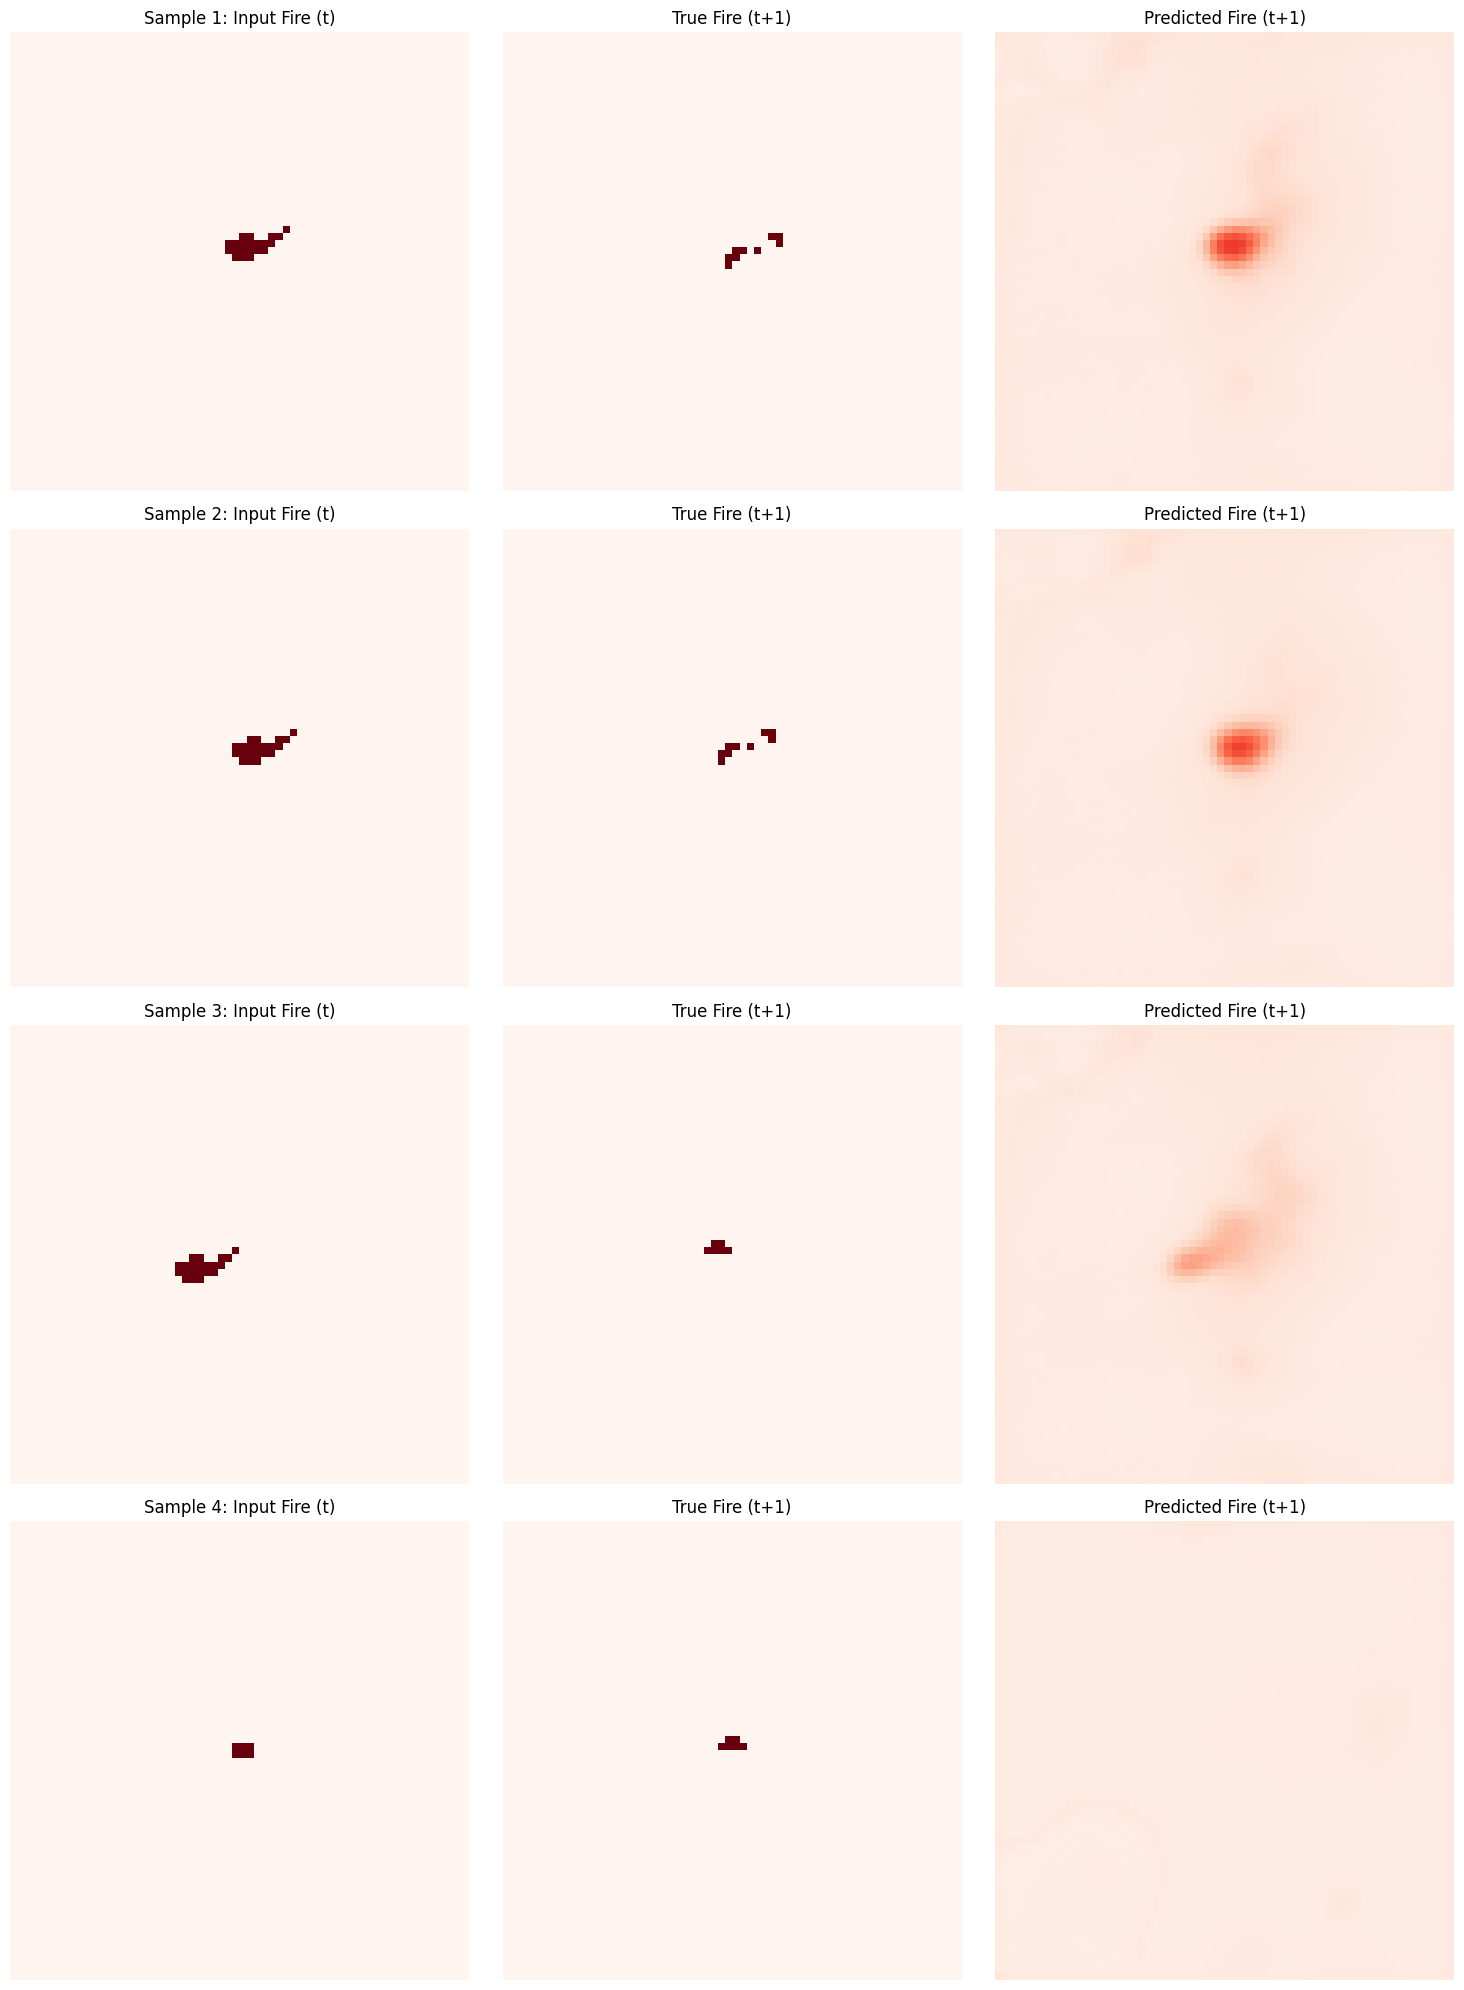


📊 PREDICTION STATISTICS:
🔥 True fire pixels in displayed samples: 30
🎯 Predicted fire pixels (threshold > 0.5): 24
📈 Average prediction confidence: 0.0733


In [5]:
# --- EXECUTION FOR THE COMBINED TIME-SERIES MODEL WITH UNET++ ---

# 1. Load data using the CombinedFireDataProcessor (no change here)
combined_processor = CombinedFireDataProcessor(num_timesteps=4)
X_spatial_combined, y_spatial_combined = combined_processor.load_raw_spatial_data(max_sequences=500) # Using a stable subset

# 2. Train the UNet++ model with the combined data
final_model_combined_pp = None 
cv_results_combined_pp = []

if X_spatial_combined is not None:
    print("\n--- Training COMBINED UNet++ Model ---")
    
    # The training function will now automatically use the FireUNetPlusPlus model
    final_model_combined_pp, cv_results_combined_pp = train_fire_unet_cv_pytorch(
        X_spatial_combined, y_spatial_combined,
        n_splits=3,
        epochs=15, 
        batch_size=4 
    )
    
    if cv_results_combined_pp:
        print("\n🎉 COMBINED UNet++ TRAINING COMPLETED!")
    else:
        print(f"❌ Combined UNet++ training failed!")
else:
    print(f"❌ Cannot train Combined UNet++ - no data loaded!")
    
# 3. Visualize the results from the UNet++ model
if final_model_combined_pp is not None:
    print(f"\n🎨 GENERATING VISUALIZATIONS for COMBINED UNet++ model...")
    
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    train_indices, val_indices = list(kfold.split(X_spatial_combined))[-1]
    
    X_train_last_fold = X_spatial_combined[train_indices]
    X_test_viz = X_spatial_combined[val_indices]
    y_test_viz = y_spatial_combined[val_indices]
    
    num_viz_samples = min(4, len(X_test_viz))
    if num_viz_samples > 0:
        X_train_t = np.transpose(X_train_last_fold, (0, 3, 1, 2))
        channel_means = np.mean(X_train_t, axis=(0, 2, 3), keepdims=True)
        channel_stds = np.std(X_train_t, axis=(0, 2, 3), keepdims=True)
        channel_stds[channel_stds == 0] = 1

        X_test_viz_t = np.transpose(X_test_viz[:num_viz_samples], (0, 3, 1, 2))
        X_test_norm_t = (X_test_viz_t - channel_means) / channel_stds
        X_test_norm = np.transpose(X_test_norm_t, (0, 2, 3, 1))
        y_test_binary = (y_test_viz[:num_viz_samples] > 0.1).astype(np.float32)
        
        visualize_fire_predictions_pytorch(
            final_model_combined_pp, X_test_norm, y_test_binary, num_samples=num_viz_samples
        )
else:
    print(f"\n⚠️ Combined UNet++ model not available for evaluation.")